Notes:
- doesn't work even without transit
- try changing priors

Found bug! Independent variable = time for all submodels!!!

In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter
plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.2.2


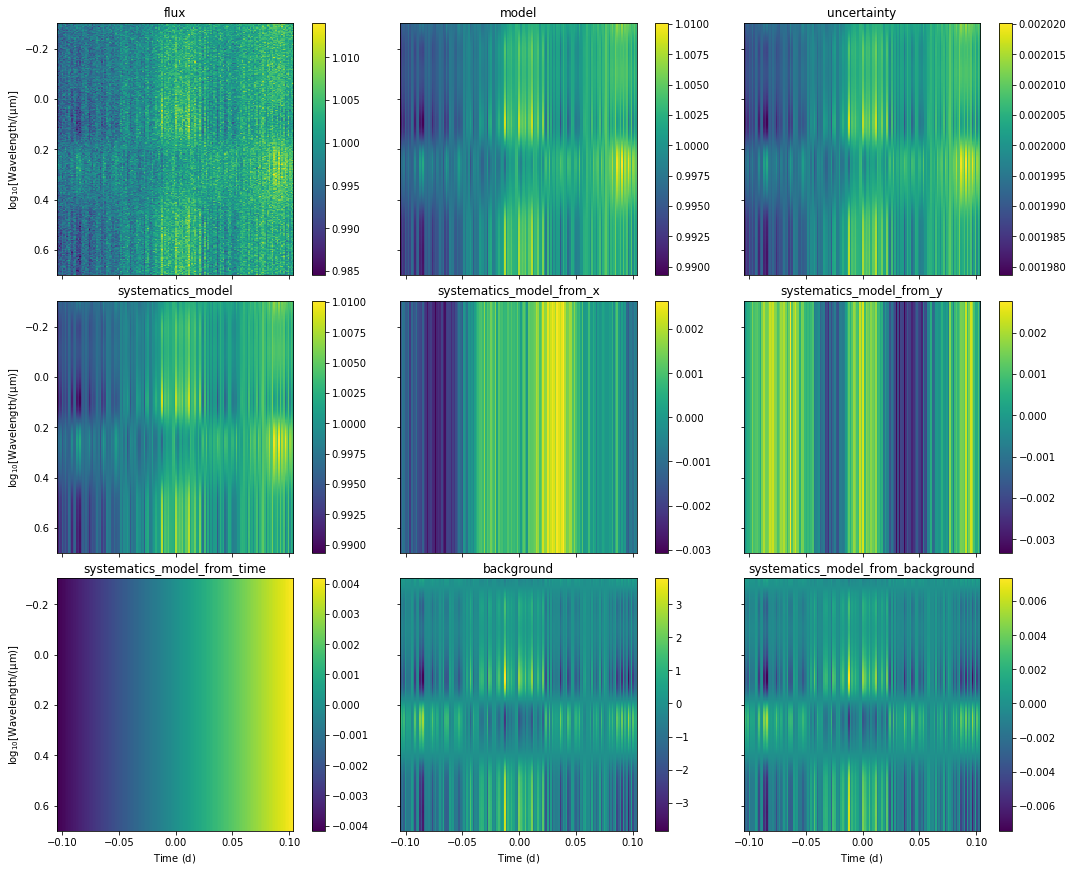

In [2]:
s = SimulatedRainbow().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500) #inject_transit().
s.imshow_quantities();
s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)

In [3]:
# set up transit model:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.initialize_empty_model()
b.setup_parameters(
    p_0 = 1.0,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.initialize_empty_model()
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.initialize_empty_model()
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.initialize_empty_model()
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

In [4]:
b_x.parameters

{'sx_p_0': <🧮 Fixed | 0.0 🧮>,
 'sx_p_1': <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='p_1') 🧮>}

In [5]:
b.parameters

{'stime_p_0': <🧮 Fixed | 1.0 🧮>,
 'stime_p_1': <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='p_1') 🧮>}

In [4]:
cm = b + b_x - b_y + b_bkg

In [7]:
cm

<chromatic combined model 🌈, models: stime(<chromatic polynomial model 🌈>) + sx(<chromatic polynomial model 🌈>) - sy(<chromatic polynomial model 🌈>) + sbkg(<chromatic polynomial model 🌈>)

In [8]:
cm.chromatic_models

{'stime': <chromatic polynomial model 🌈>,
 'sx': <chromatic polynomial model 🌈>,
 'sy': <chromatic polynomial model 🌈>,
 'sbkg': <chromatic polynomial model 🌈>}

In [9]:
cm.how_to_combine

['+', '-', '+']

In [10]:
cm.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

stime_p_0 =
  <🧮 Fixed | 1.0 🧮>

stime_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='stime_p_1') 🧮>

sx_p_0 =
  <🧮 Fixed | 0.0 🧮>

sx_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sx_p_1') 🧮>

sy_p_0 =
  <🧮 Fixed | 0.0 🧮>

sy_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sy_p_1') 🧮>

sbkg_p_0 =
  <🧮 Fixed | 0.0 🧮>

sbkg_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sbkg_p_1') 🧮>



In [5]:
cm.attach_data(s)
cm.setup_lightcurves()
cm.setup_likelihood()

stime_p_0 1.0
stime_p_1 stime_p_1 ~ Normal
[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), Elemwise{mul,no_inplace}.0] 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
stime_p_0 1.0
stime_p_1 stime_p_1 ~ Normal
[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), Elemwise{mul,no_inplace}.0] 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), Elemwise{mul,no_inplace}.0] 
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.
  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0.
 -0. -0. -0. -0. -0. -0. -0.]
sbkg_p_0 0.0
sbkg_p_1 sbkg_p_1 ~ Normal
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), Elemwise{mul,no_inplace}.0] 
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.
  0. -0.  0.  0. -0.  0.  0.

In [21]:
print(cm.chromatic_models)
print()
print(cm.pymc3_model)

{'stime': <chromatic polynomial model 🌈>, 'sx': <chromatic polynomial model 🌈>, 'sy': <chromatic polynomial model 🌈>, 'sbkg': <chromatic polynomial model 🌈>}

        stime_p_1 ~ Normal
           sx_p_1 ~ Normal
           sy_p_1 ~ Normal
         sbkg_p_1 ~ Normal
wavelength_0_data ~ Normal
wavelength_1_data ~ Normal
wavelength_2_data ~ Normal
wavelength_3_data ~ Normal
wavelength_4_data ~ Normal


In [22]:
## combine the models - old method!
# cm = CombinedModel()
# cm.initialize_empty_model()
# cm.attach_models({'transit':t,'time':b,'x':b_x,'y':b_y,'background':b_bkg}) #'transit':t,
# cm.attach_data(s)
# cm.setup_lightcurves()
# cm.setup_likelihood()
# print(cm.chromatic_models)
# print(cm.pymc3_model)

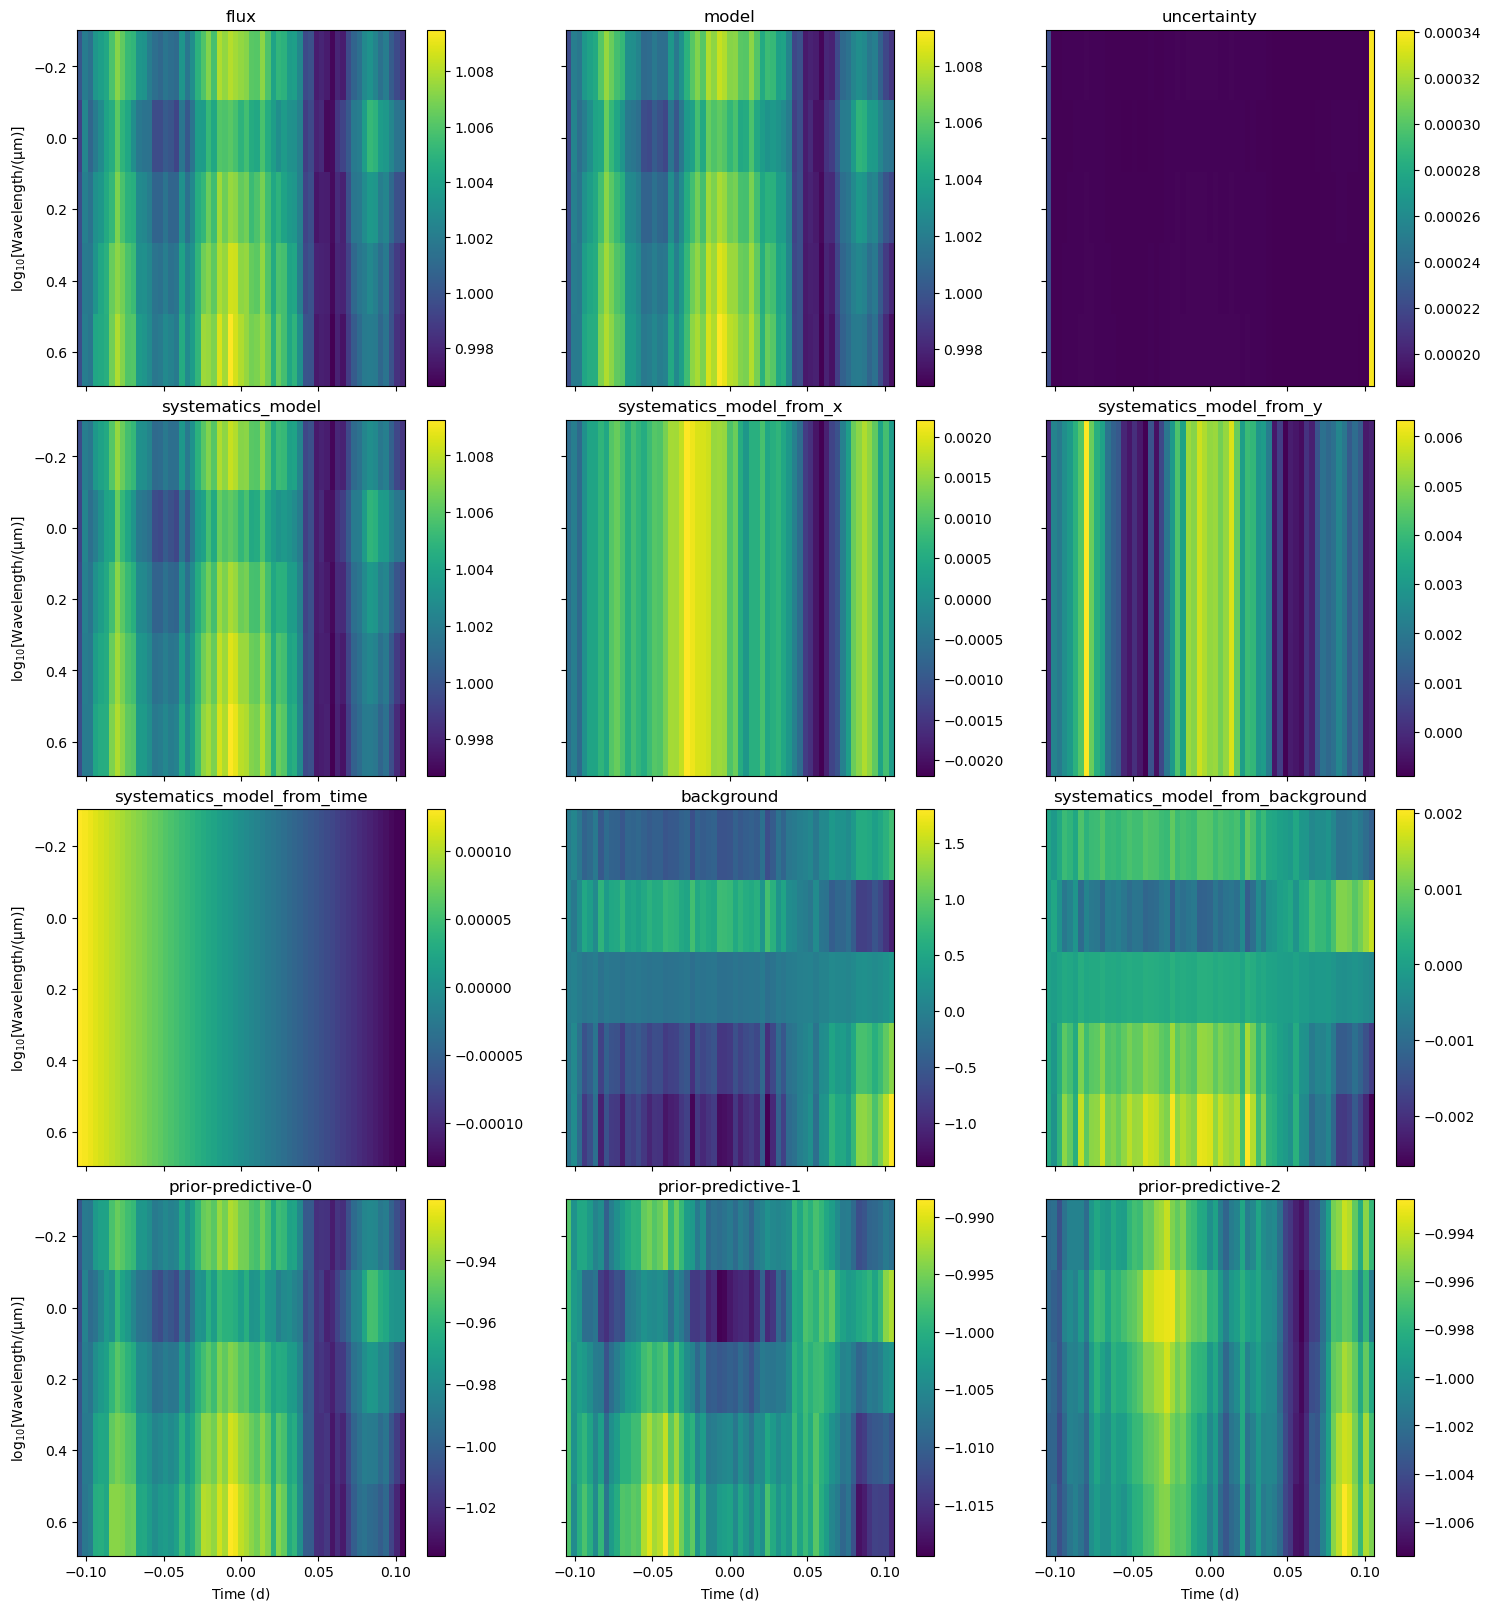

In [23]:
cm.plot_priors()

In [24]:
# opt = cm.optimize()
cm.sample(tune=2000, draws=2000, cores=12, chains=4)
cm.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 0.830566817255349, but should be close to 0.9. Try to increase the number of tuning steps.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.9. Try to increase the number of tuning steps.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.988405034714014, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The e

               mean        sd    hdi_3%   hdi_97%  mcse_mean   mcse_sd  \
stime_p_1  0.000525  0.000225  0.000288  0.000970   0.000108  0.000082   
sx_p_1     0.507781  0.187900  0.301190  0.833673   0.088700  0.067319   
sy_p_1     0.704203  0.260671  0.417002  1.156778   0.123046  0.093385   
sbkg_p_1  -0.181835  0.067339 -0.298510 -0.107715   0.031790  0.024127   

           ess_bulk   ess_tail     r_hat  
stime_p_1  4.718673  11.396021  2.646881  
sx_p_1     4.894395  11.519636  2.406758  
sy_p_1     4.895467  11.519636  2.404548  
sbkg_p_1   4.893916  11.519636  2.406976  



🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

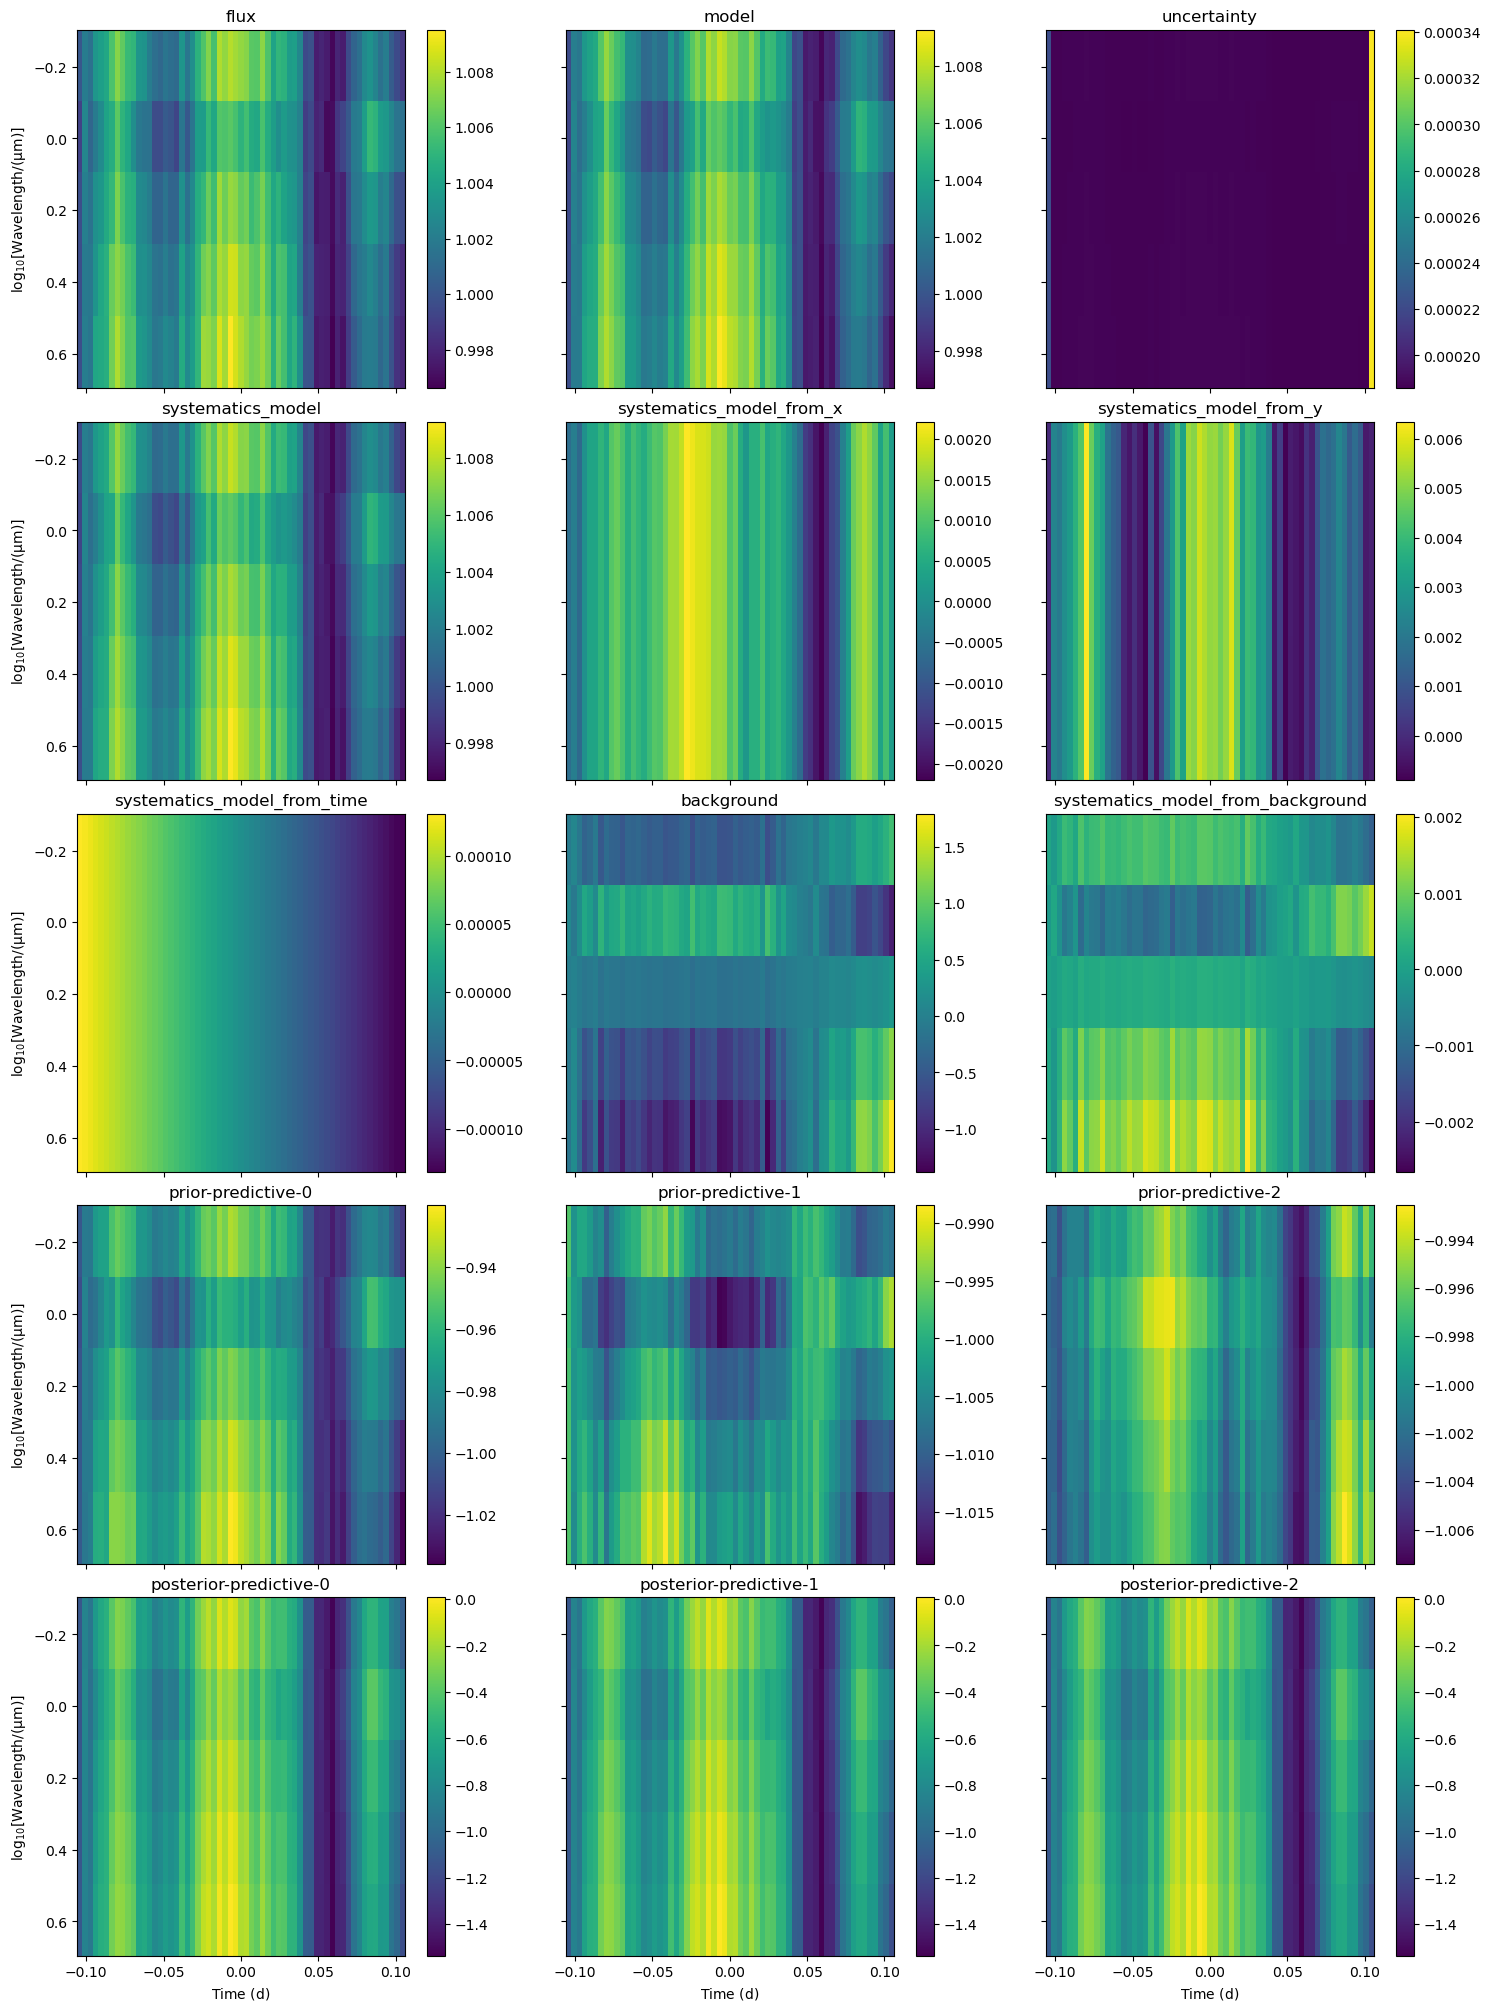

In [25]:
cm.plot_posteriors()

In [26]:
cm.summary['mean']

stime_p_1    0.000525
sx_p_1       0.507781
sy_p_1       0.704203
sbkg_p_1    -0.181835
Name: mean, dtype: float64

In [27]:
print(s.metadata['systematics_equation'])
print()
for k, v in s.metadata['systematics_components'].items():
    print(f'{k:>20} = {repr(v)}')

f = 1
  + c_x*(x - offset_x)/sigma_x
  + c_y*(y - offset_y)/sigma_y
  + c_time*(time - offset_time)/sigma_time
  + c_background*(background - offset_background)/sigma_background

            linear_x = 'c_x*(x - offset_x)/sigma_x'
                 c_x = -0.0014817392785131704
            offset_x = 0
             sigma_x = 1
            linear_y = 'c_y*(y - offset_y)/sigma_y'
                 c_y = 0.004384241779937732
            offset_y = 0
             sigma_y = 1
         linear_time = 'c_time*(time - offset_time)/sigma_time'
              c_time = -7.645407953634796e-05
         offset_time = <Quantity -0.00069444 d>
          sigma_time = <Quantity 0.06013932 d>
   linear_background = 'c_background*(background - offset_background)/sigma_background'
        c_background = -0.001482963960855906
   offset_background = 0
    sigma_background = 1


In [55]:
meta = s.metadata['systematics_components']
systematics_model = 1 + \
        (meta['c_x'] * s.x) + \
        (meta['c_y'] * s.y) + \
        (meta['c_time'] * ((s.time.to_value("day")-meta['offset_time'])/meta['sigma_time'].to_value("day"))) + \
        (meta['c_background'] * s.background) 
cm.data.fluxlike['test_residuals-0'] = cm.data.fluxlike['posterior-predictive-0'] - systematics_model

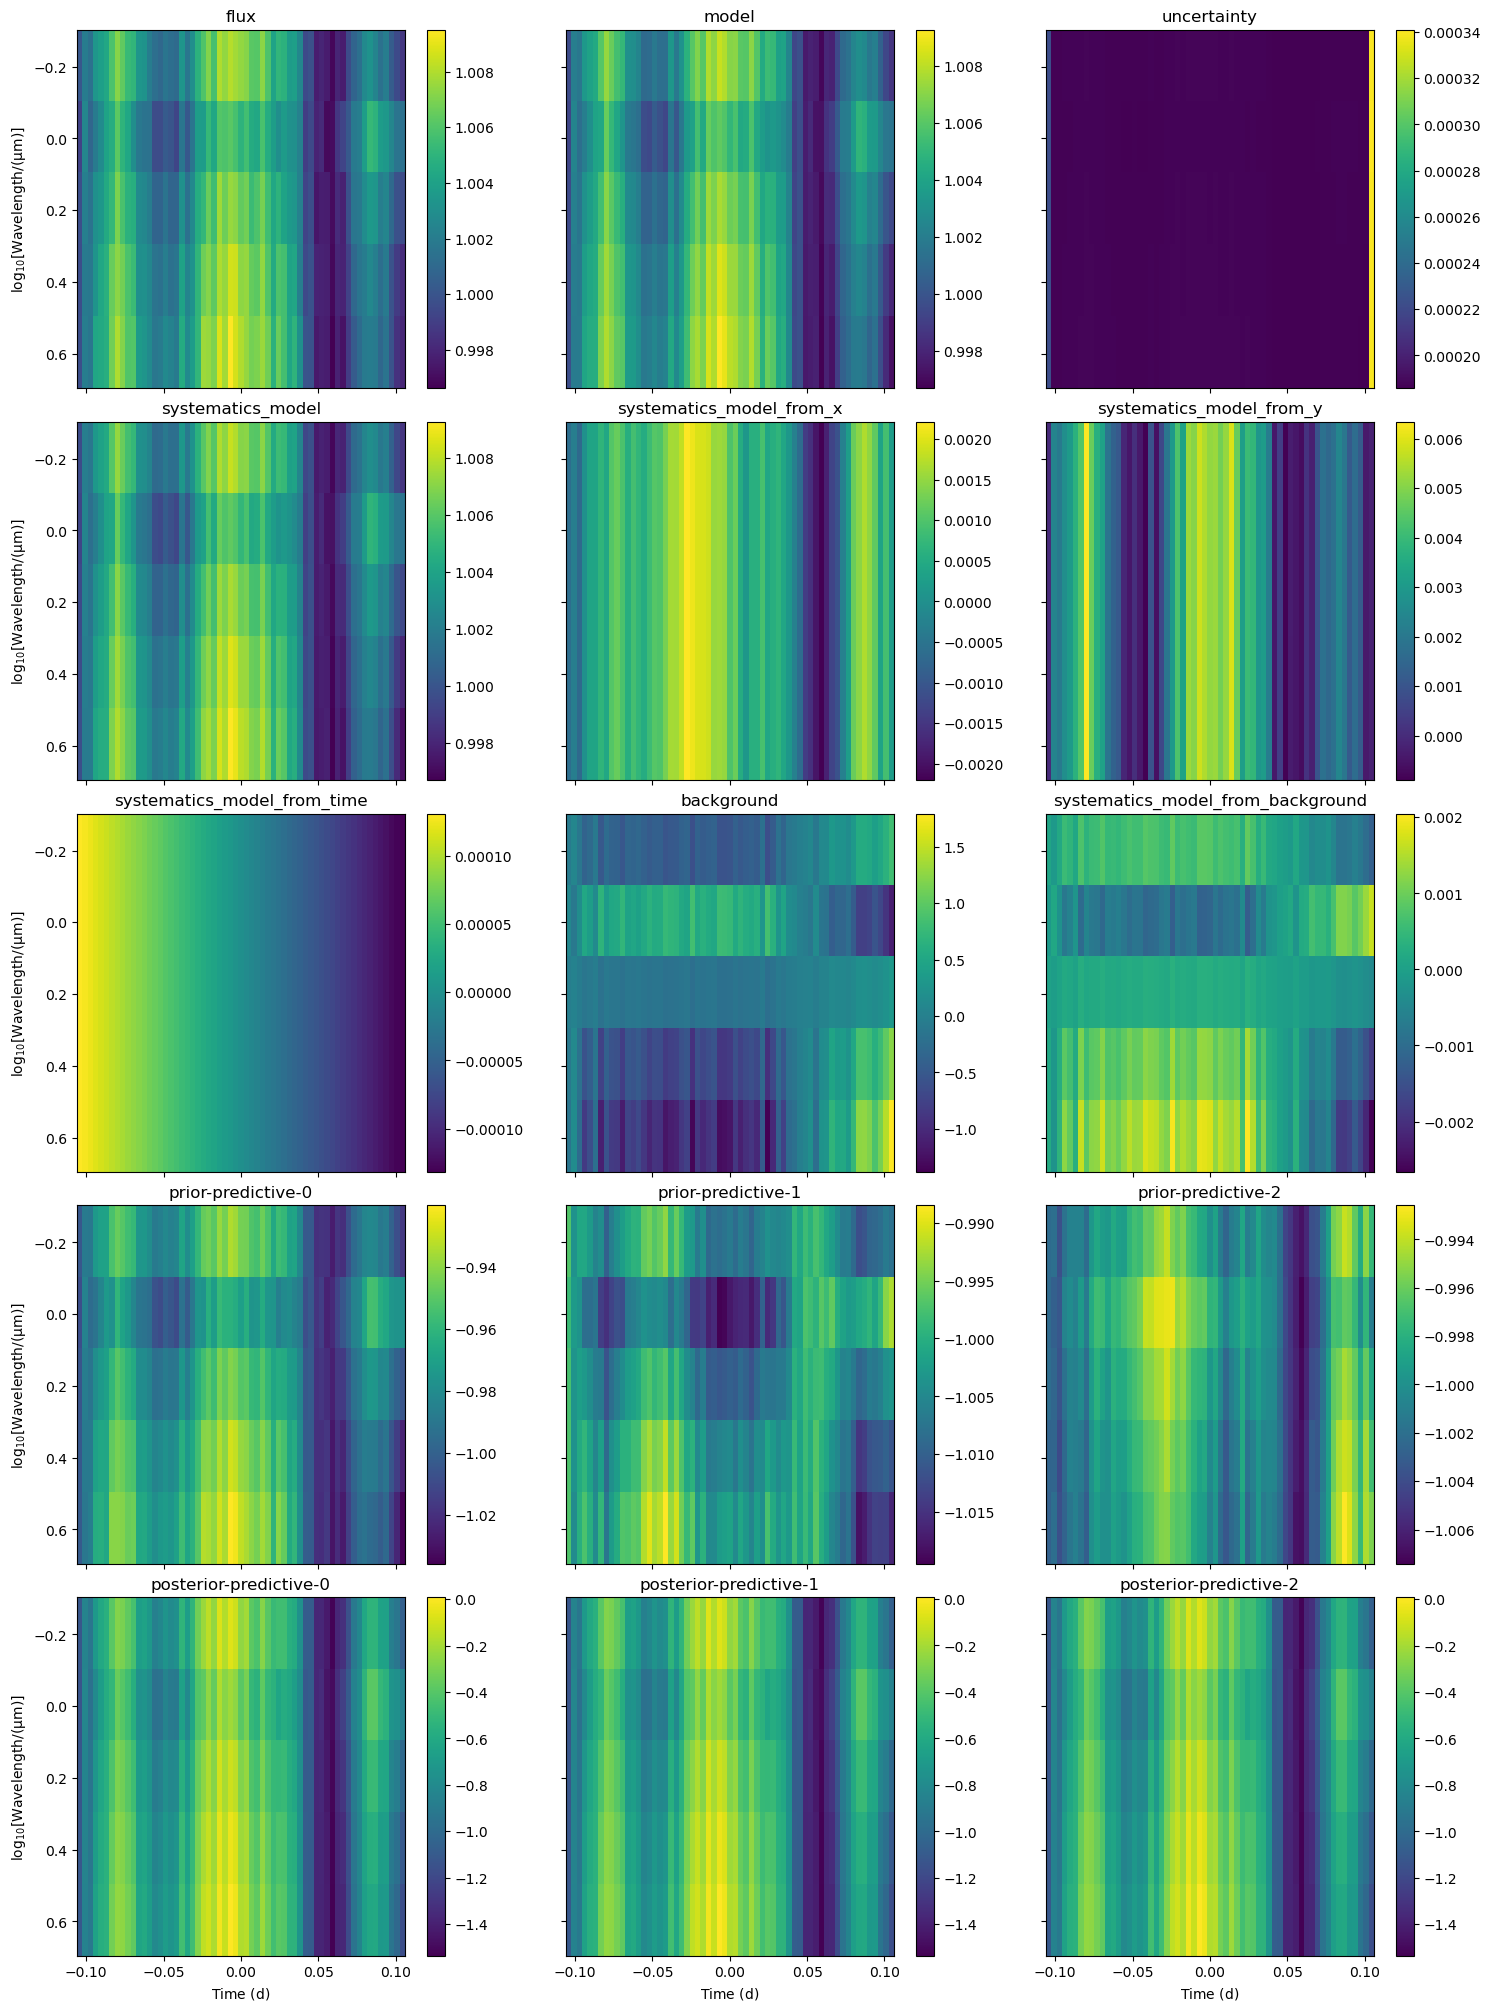

In [28]:
cm.data.imshow_quantities()

Got error No model on context stack. trying to find log_likelihood in translation.

🌈 Warning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'stime_p_1'}>,
        <AxesSubplot:title={'center':'stime_p_1'}>],
       [<AxesSubplot:title={'center':'sx_p_1'}>,
        <AxesSubplot:title={'center':'sx_p_1'}>],
       [<AxesSubplot:title={'center':'sy_p_1'}>,
        <AxesSubplot:title={'center':'sy_p_1'}>],
       [<AxesSubplot:title={'center':'sbkg_p_1'}>,
        <AxesSubplot:title={'center':'sbkg_p_1'}>]], dtype=object)

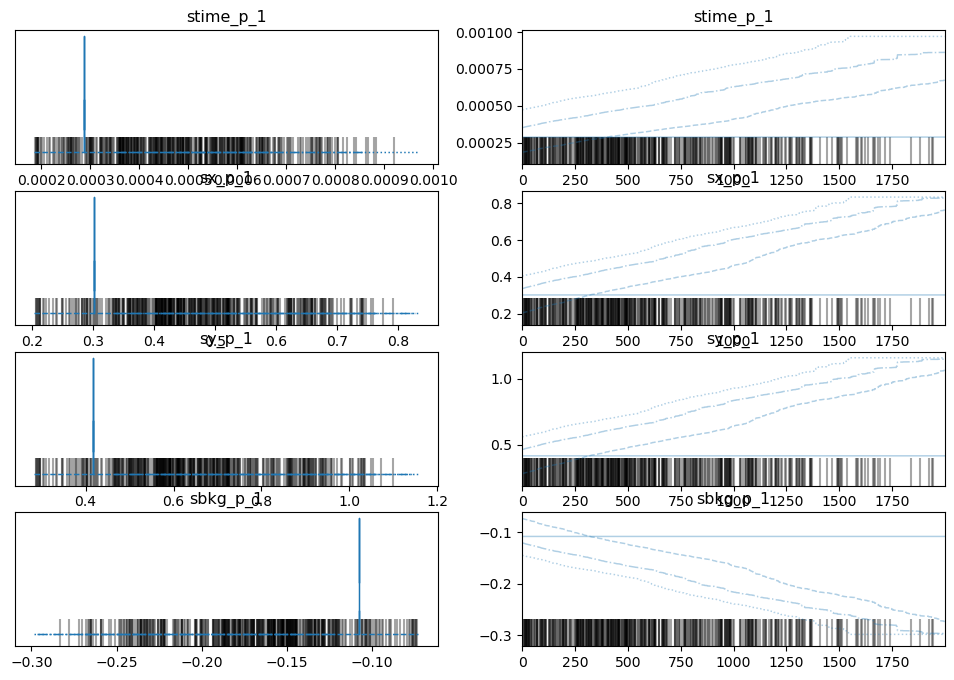

In [29]:
az.plot_trace(cm.trace)

optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -16534.96855365092 -> 2215.8426886025154



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.000173 -0.004298 -0.001117  -0.025948
recovered  0.000118 -0.004336 -0.001113  -0.026378 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -17239418752.02444 -> -14138689950.841412



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.000173 -0.004298 -0.001117  -0.025948
recovered  1.021267  1.856332 -0.016778  -2.836185 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -102285.27602287997 -> 2195.239551421554



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.004203 -0.001475  0.001591  -0.046156
recovered  0.004177 -0.001439  0.001560  -0.045793 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -17201097001.744034 -> -8532336844.011006



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.004203 -0.001475  0.001591  -0.046156
recovered  0.808502  1.413752  1.234715  15.976375 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -18361.69603802554 -> 2209.7473424528007



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.002368 -0.001946  0.000736  -0.011663
recovered  0.002344 -0.001928  0.000733  -0.011907 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -17243129478.07721 -> -15078016075.867386



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.002368 -0.001946  0.000736  -0.011663
recovered  0.306914  0.816133 -2.426487  -3.844761 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -6326.255351848491 -> 2213.768432043934



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.000623 -0.001708 -0.000428   0.000139
recovered -0.000623 -0.001692 -0.000453   0.000060 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -17269195496.59709 -> -4614869294.023021



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.000623 -0.001708 -0.000428   0.000139
recovered  0.321192 -2.473169  0.392720   4.694848 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -33657.34348161185 -> 2226.439567383254



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.002288 -0.001464 -0.002174   0.001400
recovered  0.002274 -0.001468 -0.002161   0.001271 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -17265844183.68847 -> -13185102524.17691



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.002288 -0.001464 -0.002174   0.001400
recovered -1.685786  0.031315 -0.011517  -2.293087 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -28423.618312286308 -> 2243.2556237919475



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.000151 -0.002519  0.002089   0.016280
recovered -0.000139 -0.002497  0.002032   0.016217 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -17272583666.65355 -> -8094126507.961566



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.000151 -0.002519  0.002089   0.016280
recovered  0.643682 -1.790535 -0.046652   3.063087 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -91428.14538885326 -> 2208.0458436267368



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.000724  0.004714 -0.000906   0.041190
recovered -0.000693  0.004722 -0.000898   0.041292 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -17300031385.00851 -> -7791423714.328177



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.000724  0.004714 -0.000906   0.041190
recovered  0.720917  1.237291  0.925489  -2.841728 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -28604.957059331366 -> 2213.9646036756512



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.000251 -0.000032  0.002703   0.044487
recovered  0.000222 -0.000018  0.002702   0.044547 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -17248205182.706017 -> -2237224180.2127194



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected   0.000251 -0.000032  0.002703   0.044487
recovered -0.873279 -1.225642  0.331266   4.764420 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -111606.31252617943 -> 2233.5012943666925



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.003023 -0.002008 -0.000698   0.026914
recovered -0.003042 -0.001964 -0.000697   0.027287 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -17301262459.39957 -> -8106943231.501065



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.003023 -0.002008 -0.000698   0.026914
recovered  0.321779 -1.189443  0.584432 -12.938852 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -19985.20233045914 -> 2217.6354439530924



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.000865  0.002565 -0.001202  -0.010779
recovered -0.000874  0.002573 -0.001190  -0.010146 
*********



optimizing logp for variables: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Optimization terminated successfully.
logp: -17264999848.711212 -> -13427939613.723854



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.



*********
              sx_p_1    sy_p_1  sbkg_p_1  stime_p_1
Injected  -0.000865  0.002565 -0.001202  -0.010779
recovered  0.550792  1.380034  0.459490   7.226381 
*********



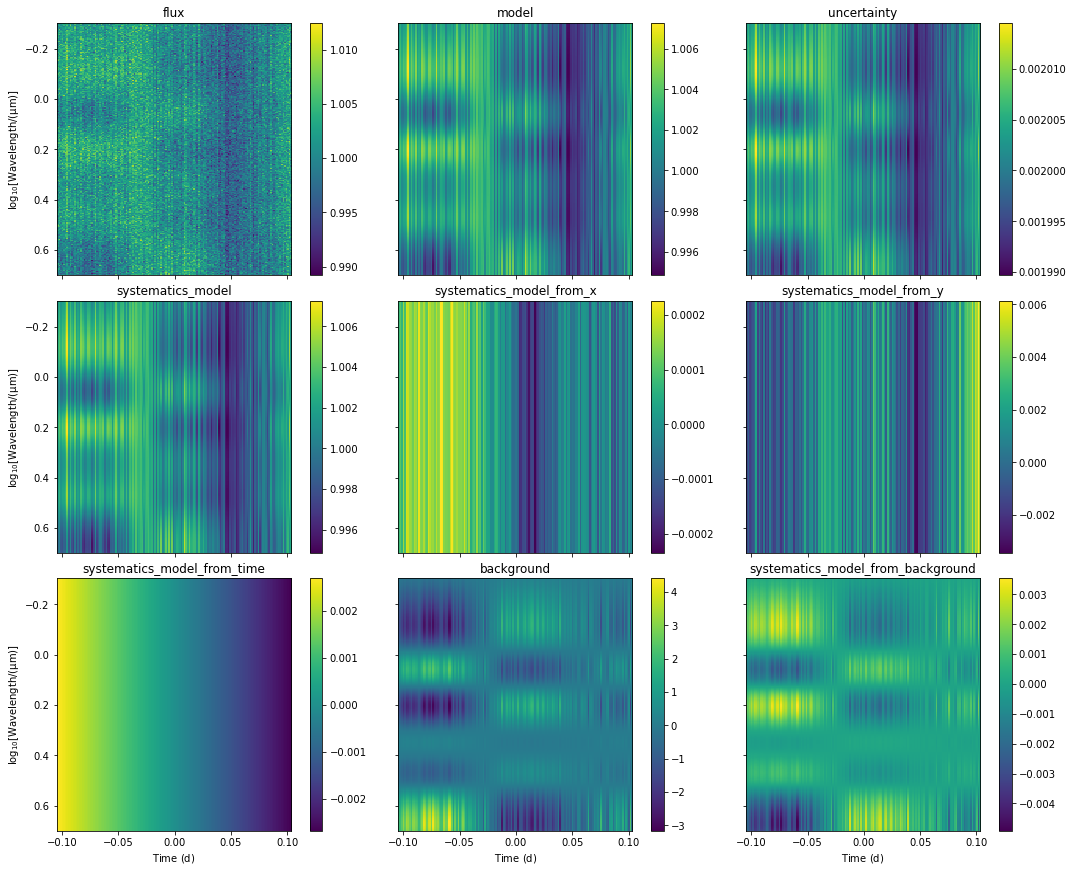

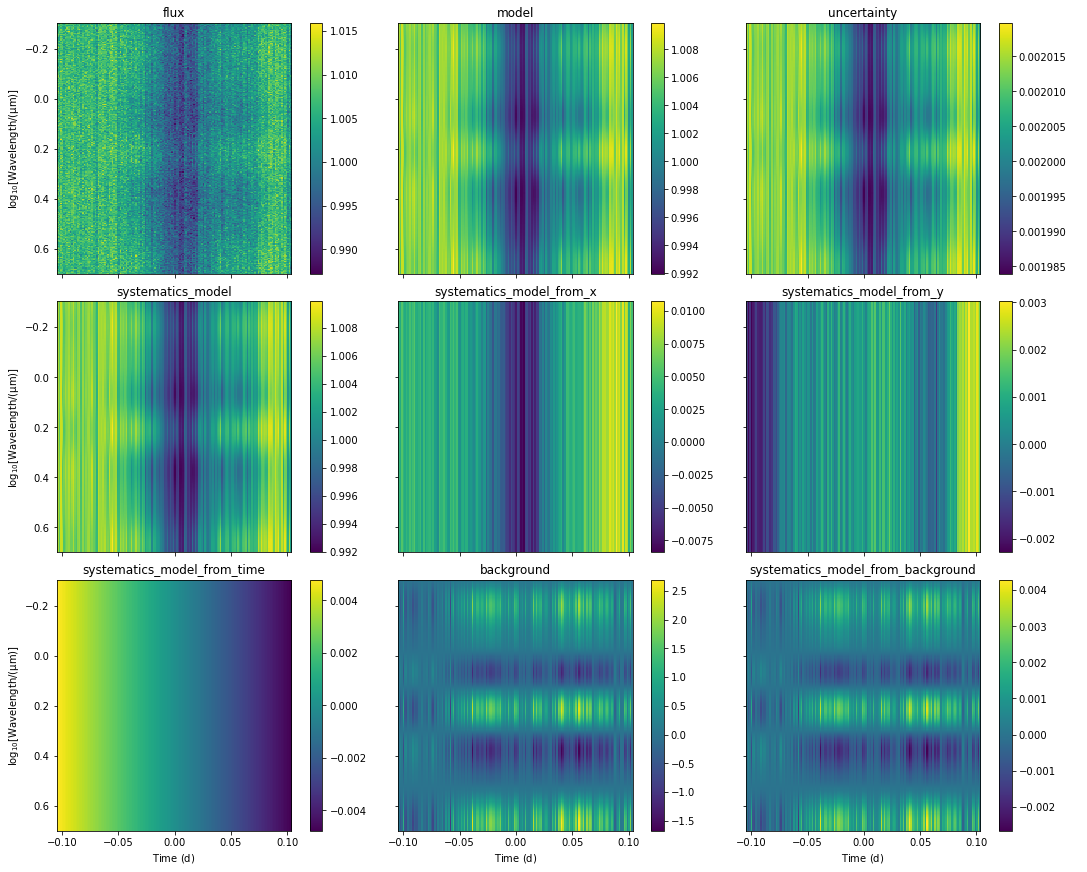

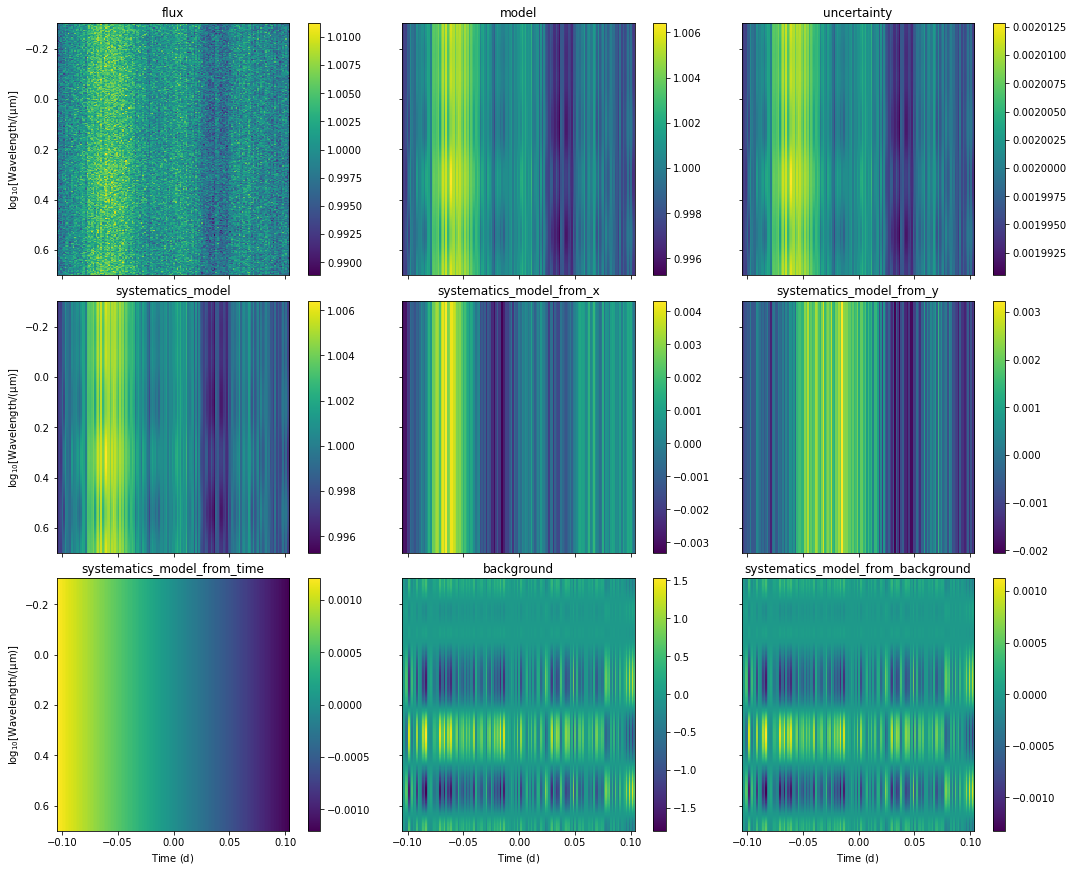

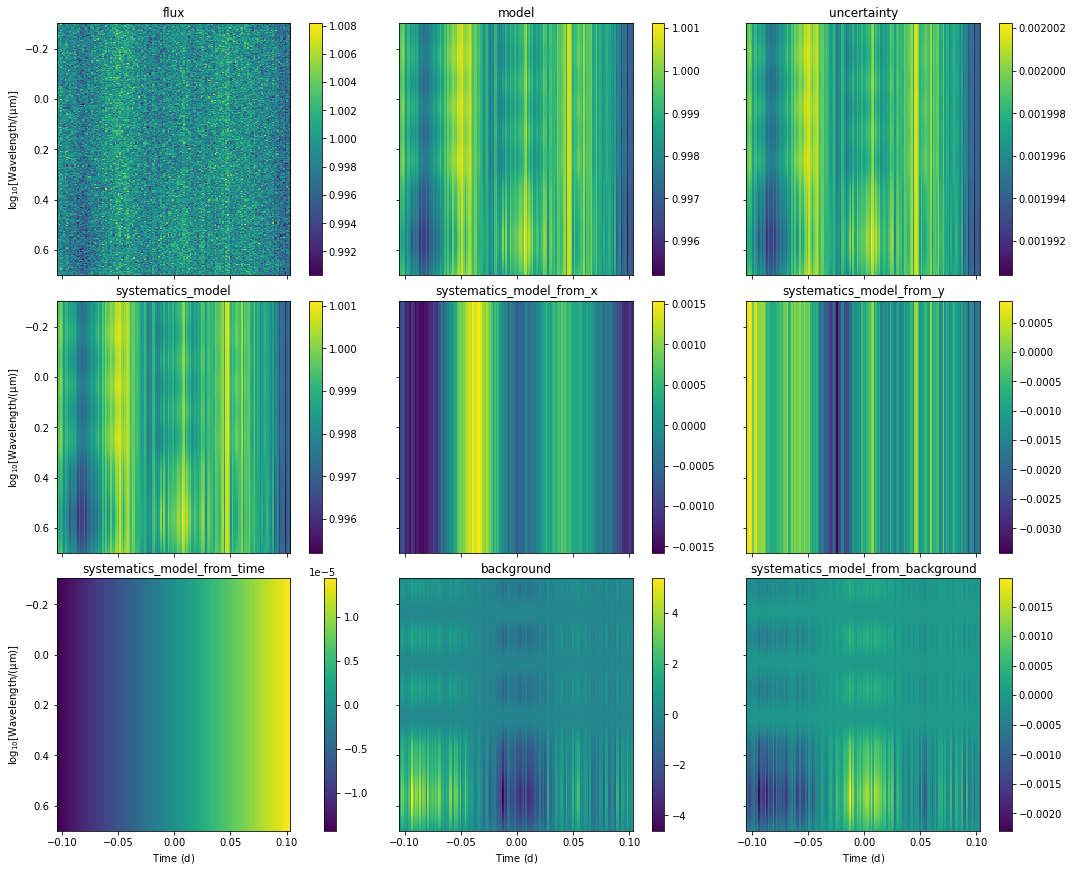

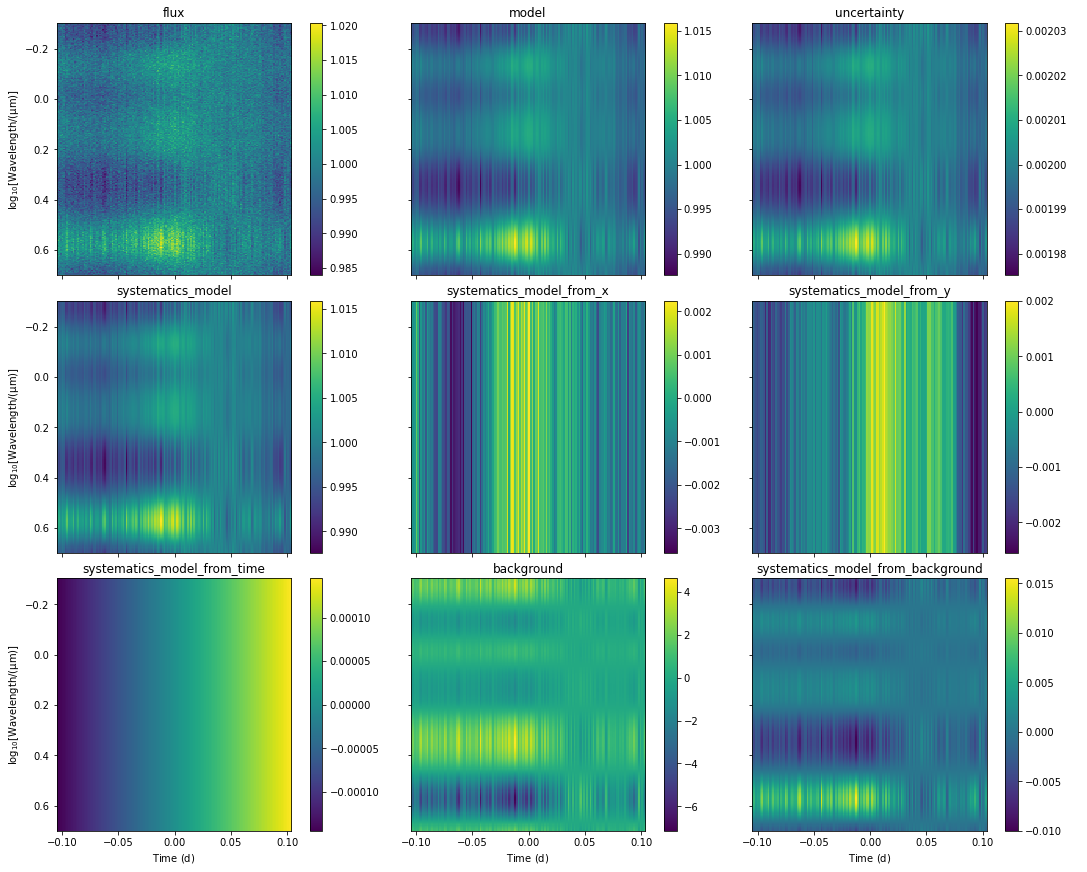

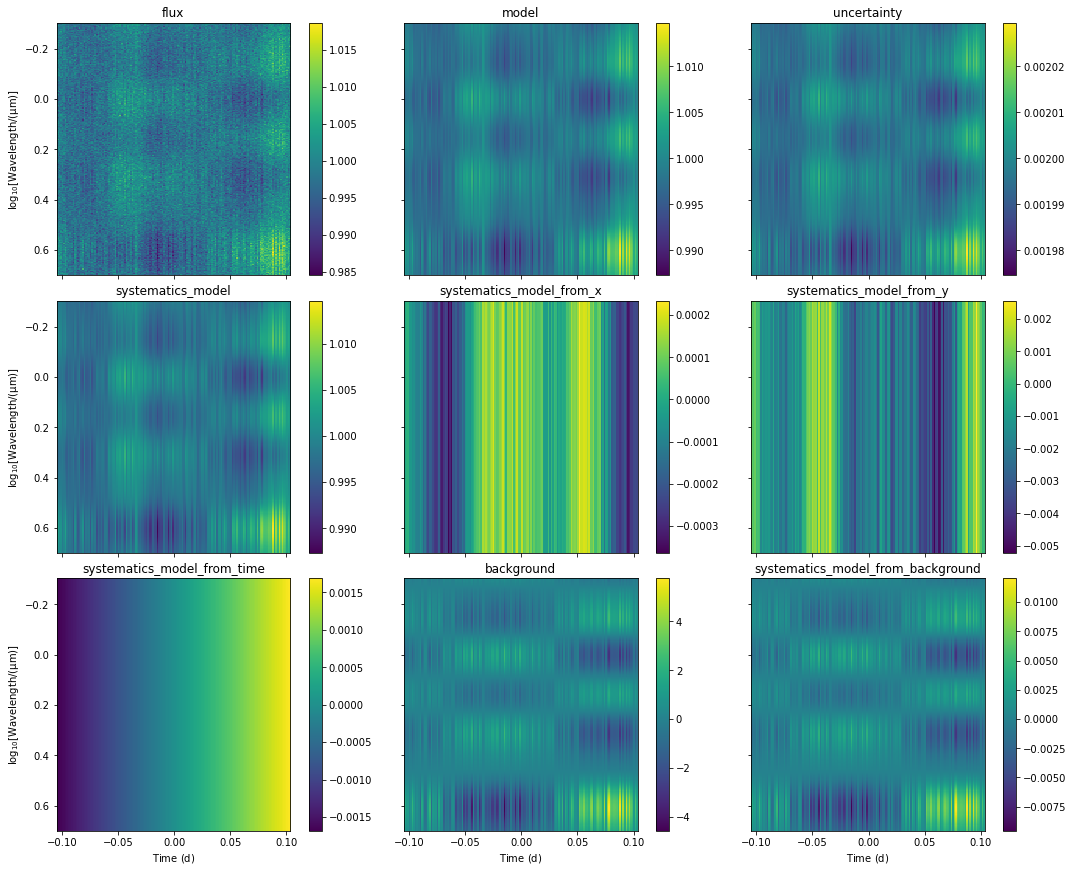

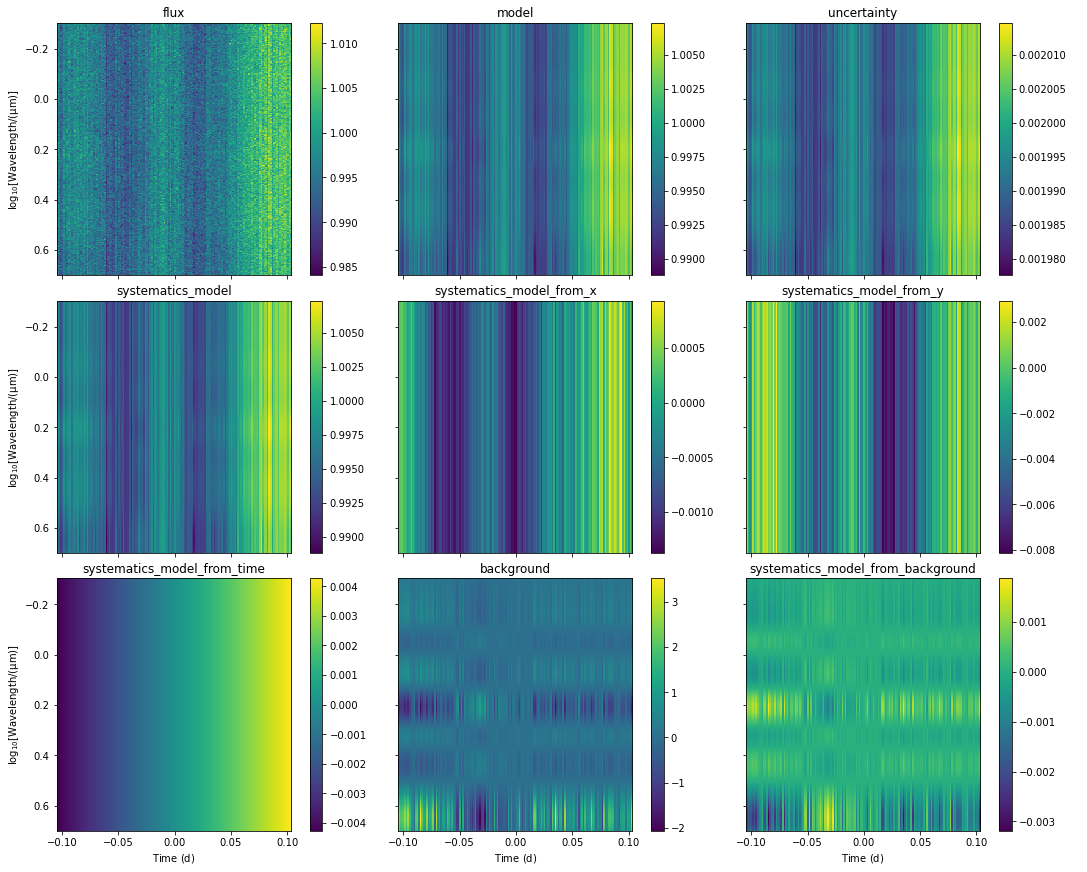

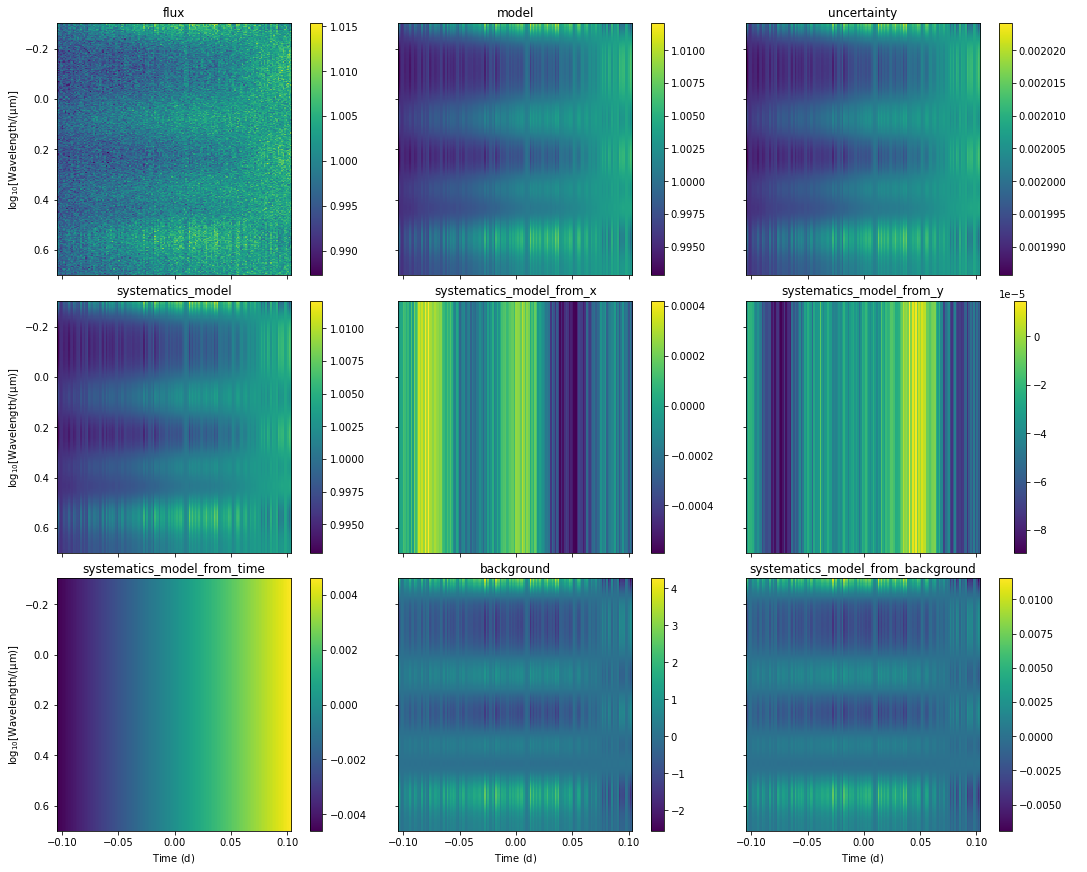

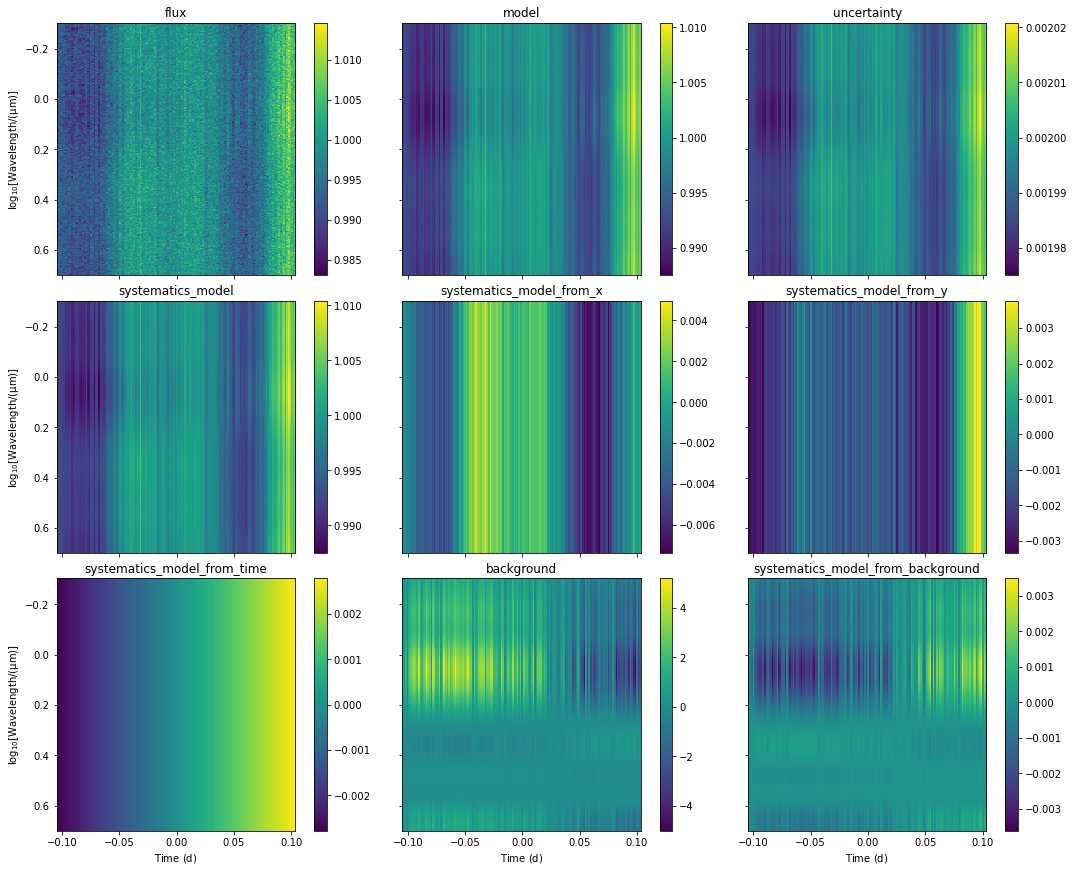

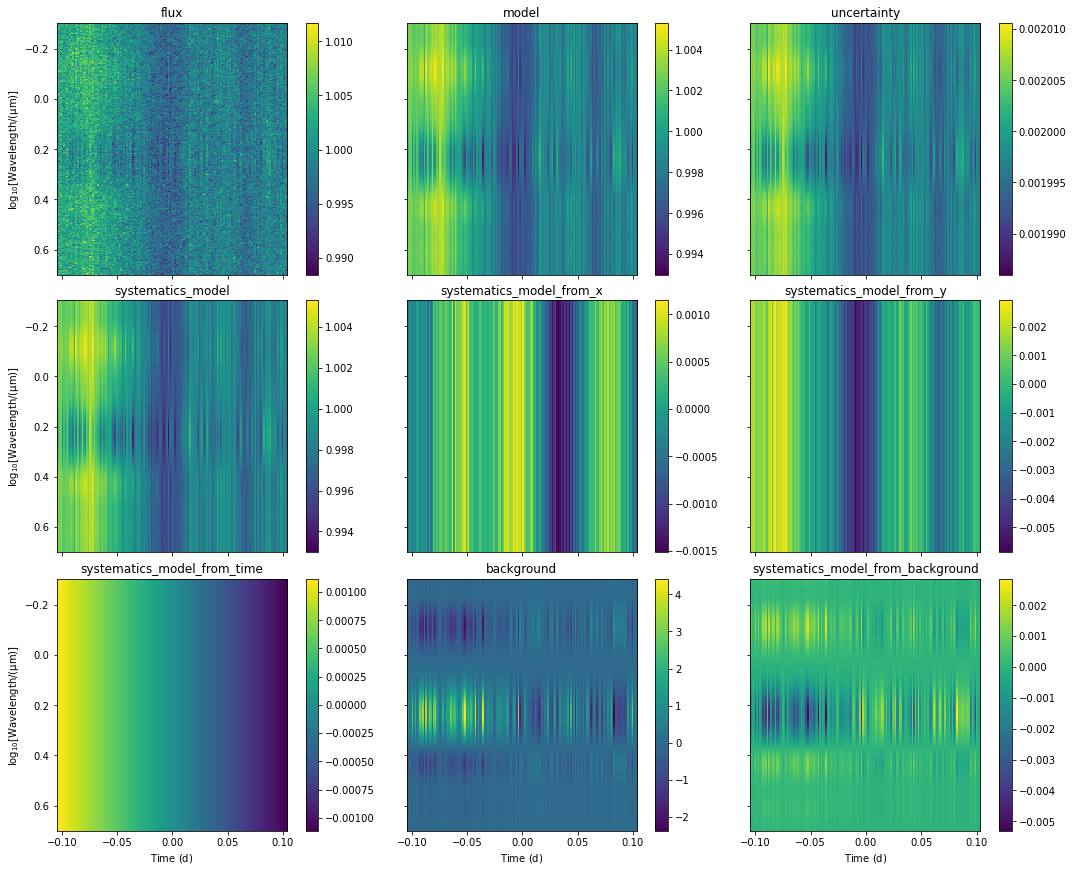

In [6]:
for i in range(10):
    # create simulated rainbow + noise
    s = SimulatedRainbow().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500) #inject_transit().
    s.imshow_quantities();
    s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)
    
    cm = b + b_x + b_y + b_bkg
    cm.attach_data(s)
    cm.setup_lightcurves()
    cm.setup_likelihood()
#     print(cm.chromatic_models)
#     print(cm.pymc3_model)
    opt = cm.optimize()
    cm.sample(start=opt, tune=1000, draws=1000, cores=12, chains=4)
    cm.summarize(print_table=False, round_to=7, fmt='wide')
    summary = cm.summary['mean']
    
    meta = s.metadata['systematics_components']
    meta_dict = {'sx_p_1':[meta['c_x']], 'sy_p_1':[meta['c_y']], 'sbkg_p_1': [meta['c_background']], 'stime_p_1': [meta['c_time']/meta['sigma_time'].to_value("day")]}
    
    meta_df = pd.DataFrame(meta_dict,index=['Injected'])
    summary_df = pd.DataFrame(summary).rename({'mean':"recovered"},errors="raise",axis=1).transpose()
    print("\n*********\n", pd.concat([meta_df,summary_df]),"\n*********\n")
    
    cm = b - b_x - b_y - b_bkg
    cm.attach_data(s)
    cm.setup_lightcurves()
    cm.setup_likelihood()
    opt = cm.optimize()
    cm.sample(start=opt, tune=1000, draws=1000, cores=12, chains=4)
    cm.summarize(print_table=False, round_to=7, fmt='wide')
    summary = cm.summary['mean']
    
    meta = s.metadata['systematics_components']
    meta_dict = {'sx_p_1':[meta['c_x']], 'sy_p_1':[meta['c_y']], 'sbkg_p_1': [meta['c_background']], 'stime_p_1': [meta['c_time']/meta['sigma_time'].to_value("day")]}
    
    meta_df = pd.DataFrame(meta_dict,index=['Injected'])
    summary_df = pd.DataFrame(summary).rename({'mean':"recovered"},errors="raise",axis=1).transpose()
    print("\n*********\n", pd.concat([meta_df,summary_df]),"\n*********\n")